In [1]:
!pip install xgboost
!pip install imblearn



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression


from xgboost import XGBClassifier
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score, f1_score,precision_score, recall_score, roc_auc_score, average_precision_score,roc_curve, precision_recall_curve, hamming_loss
%matplotlib inline


from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import gc

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data=pd.read_csv("/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_1.csv")
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_2.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_3.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_4.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/final_1.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/final_2.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/final_3.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/final_4.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/final_5.csv")])

/tmp/ipython-input-4-3093493103.py:1: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv("/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_1.csv")
/tmp/ipython-input-4-3093493103.py:2: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_2.csv")])
/tmp/ipython-input-4-3093493103.py:3: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_3.csv")])
/tmp/ipython-input-4-3093493103.py:4: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_4.csv")])


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5500363 entries, 0 to 431
Data columns (total 46 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   pkSeqID                           int64  
 1   stime                             float64
 2   flgs                              object 
 3   flgs_number                       int64  
 4   proto                             object 
 5   proto_number                      int64  
 6   saddr                             object 
 7   sport                             object 
 8   daddr                             object 
 9   dport                             object 
 10  pkts                              int64  
 11  bytes                             int64  
 12  state                             object 
 13  state_number                      int64  
 14  ltime                             float64
 15  seq                               int64  
 16  dur                               float64
 17

In [ ]:
data.columns

Index(['pkSeqID', 'stime', 'flgs', 'flgs_number', 'proto', 'proto_number',
       'saddr', 'sport', 'daddr', 'dport', 'pkts', 'bytes', 'state',
       'state_number', 'ltime', 'seq', 'dur', 'mean', 'stddev', 'sum', 'min',
       'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate',
       'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto',
       'TnP_Per_Dport', 'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP',
       'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport',
       'AR_P_Proto_P_Dport', 'Pkts_P_State_P_Protocol_P_DestIP',
       'Pkts_P_State_P_Protocol_P_SrcIP', 'attack', 'category', 'subcategory'],
      dtype='object')

In [5]:
data=data.drop_duplicates()

In [6]:
data=data.drop(columns=["pkSeqID","stime","flgs","proto","saddr","sport","daddr","dport","state","ltime","seq"])

In [7]:
#dropping correlated columns
data=data.drop(columns=["bytes","max","spkts","sbytes","dbytes","AR_P_Proto_P_Dport","state_number","dpkts"])

In [ ]:
data.isnull().sum()

,0
flgs_number,0
proto_number,0
pkts,0
dur,0
mean,0
stddev,0
sum,0
min,0
rate,0
srate,0


In [ ]:
data.head()

,flgs_number,proto_number,pkts,dur,mean,stddev,sum,min,rate,srate,...,AR_P_Proto_P_SrcIP,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
0,1,1,8,7.056393,0.068909,0.068909,0.137818,0.000000,0.992008,0.566862,...,1.142970,1.12704,96,75,1.133720,770,602,1,DoS,HTTP
1,1,2,2,0.000131,0.000131,0.000000,0.000131,0.000131,7633.588379,0.000000,...,0.003857,15267.20000,1,2,0.005142,2,6,1,DoS,HTTP
2,1,1,8,7.047852,0.064494,0.064494,0.128988,0.000000,0.993210,0.567549,...,1.142970,1.12704,96,75,1.135100,770,602,1,DoS,HTTP
3,1,1,8,7.047592,0.064189,0.064189,0.128378,0.000000,0.993247,0.567570,...,1.142970,1.12704,96,75,1.135140,770,602,1,DoS,HTTP
4,1,1,8,7.046841,0.063887,0.063887,0.127774,0.000000,0.993353,0.567630,...,1.142970,1.12704,96,75,1.135260,770,602,1,DoS,HTTP


In [8]:
data['category'].value_counts()

,count
category,
DDoS,1926624
DoS,1650260
Reconnaissance,91082
Normal,9549
Theft,1657


In [9]:
data["attack"].value_counts()

,count
attack,
1,3669623
0,9549


In [10]:
data["subcategory"].value_counts()

,count
subcategory,
UDP,1981230
TCP,1593180
Service_Scan,73168
OS_Fingerprint,17914
Normal,9549
HTTP,2474
Keylogging,1537
Data_Exfiltration,120


In [11]:
le = LabelEncoder()
data['category'] = le.fit_transform(data['category'])
data['subcategory'] = le.fit_transform(data['subcategory'])
data.head()

,flgs_number,proto_number,pkts,dur,mean,stddev,sum,min,rate,srate,...,AR_P_Proto_P_SrcIP,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
0,1,1,8,7.056393,0.068909,0.068909,0.137818,0.000000,0.992008,0.566862,...,1.142970,1.12704,96,75,1.133720,770,602,1,1,1
1,1,2,2,0.000131,0.000131,0.000000,0.000131,0.000131,7633.588379,0.000000,...,0.003857,15267.20000,1,2,0.005142,2,6,1,1,1
2,1,1,8,7.047852,0.064494,0.064494,0.128988,0.000000,0.993210,0.567549,...,1.142970,1.12704,96,75,1.135100,770,602,1,1,1
3,1,1,8,7.047592,0.064189,0.064189,0.128378,0.000000,0.993247,0.567570,...,1.142970,1.12704,96,75,1.135140,770,602,1,1,1
4,1,1,8,7.046841,0.063887,0.063887,0.127774,0.000000,0.993353,0.567630,...,1.142970,1.12704,96,75,1.135260,770,602,1,1,1


In [12]:
Y = data[['attack','category','subcategory']]
X= data.drop(['attack','category','subcategory'],axis=1)

In [ ]:
X.head()

,flgs_number,proto_number,pkts,dur,mean,stddev,sum,min,rate,srate,...,TnP_PDstIP,TnP_PerProto,TnP_Per_Dport,AR_P_Proto_P_SrcIP,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP
0,1,1,8,7.056393,0.068909,0.068909,0.137818,0.000000,0.992008,0.566862,...,770,772,772,1.142970,1.12704,96,75,1.133720,770,602
1,1,2,2,0.000131,0.000131,0.000000,0.000131,0.000131,7633.588379,0.000000,...,2,8,8,0.003857,15267.20000,1,2,0.005142,2,6
2,1,1,8,7.047852,0.064494,0.064494,0.128988,0.000000,0.993210,0.567549,...,770,772,772,1.142970,1.12704,96,75,1.135100,770,602
3,1,1,8,7.047592,0.064189,0.064189,0.128378,0.000000,0.993247,0.567570,...,770,772,772,1.142970,1.12704,96,75,1.135140,770,602
4,1,1,8,7.046841,0.063887,0.063887,0.127774,0.000000,0.993353,0.567630,...,770,772,772,1.142970,1.12704,96,75,1.135260,770,602


In [13]:
mi_attack = mutual_info_classif(X, Y["attack"])
mi_subcat = mutual_info_classif(X, Y["subcategory"])
mi_cat    = mutual_info_classif(X, Y["category"])
mi_avg = (mi_attack + mi_subcat + mi_cat) / 3

df_mi = pd.DataFrame({
    'feature': X.columns.tolist(),
    'MI_attack': mi_attack,
    'MI_subcategory': mi_subcat,
    'MI_category': mi_cat,
    'MI_average': mi_avg
})

df_mi_sorted = df_mi.sort_values(by='MI_average', ascending=False)
top_features = df_mi_sorted.head(20)['feature'].tolist()
X = X[top_features]


In [14]:
del mi_attack, mi_subcat, mi_cat, mi_avg, df_mi, df_mi_sorted,top_features
gc.collect()

556

In [ ]:
X.head()

,AR_P_Proto_P_Sport,AR_P_Proto_P_DstIP,TnBPDstIP,dur,AR_P_Proto_P_SrcIP,rate,srate,TnBPSrcIP,sum,TnP_PDstIP,Pkts_P_State_P_Protocol_P_DestIP,TnP_PerProto,mean,Pkts_P_State_P_Protocol_P_SrcIP,TnP_PSrcIP,TnP_Per_Dport,min,stddev,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP
0,1.133720,1.12704,201841,7.056393,1.142970,0.992008,0.566862,157426,0.137818,770,770,772,0.068909,602,602,772,0.000000,0.068909,96,75
1,0.005142,15267.20000,120,0.000131,0.003857,7633.588379,0.000000,360,0.000131,2,2,8,0.000131,6,6,8,0.000131,0.000000,1,2
2,1.135100,1.12704,201841,7.047852,1.142970,0.993210,0.567549,157426,0.128988,770,770,772,0.064494,602,602,772,0.000000,0.064494,96,75
3,1.135140,1.12704,201841,7.047592,1.142970,0.993247,0.567570,157426,0.128378,770,770,772,0.064189,602,602,772,0.000000,0.064189,96,75
4,1.135260,1.12704,201841,7.046841,1.142970,0.993353,0.567630,157426,0.127774,770,770,772,0.063887,602,602,772,0.000000,0.063887,96,75


In [15]:
model = XGBClassifier(tree_method='hist', n_jobs=-1)
model.fit(X, Y["attack"])

model1 = XGBClassifier(tree_method='hist', n_jobs=-1)
model1.fit(X, Y["subcategory"])

model2 = XGBClassifier(tree_method='hist', n_jobs=-1)
model2.fit(X, Y["category"])


importances = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_features = importance_df['feature'].head(15)

importances = model1.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_features1 = importance_df['feature'].head(15)

importances = model2.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_features2 = importance_df['feature'].head(15)


combined_features = set(top_features) | set(top_features1) | set(top_features2)
X = X[list(combined_features)]

In [16]:
del model, model1, model2, importances, importance_df, top_features, top_features1, top_features2, combined_features
gc.collect()

125

In [ ]:
X.head()

,TnBPSrcIP,N_IN_Conn_P_DstIP,Pkts_P_State_P_Protocol_P_DestIP,sum,Pkts_P_State_P_Protocol_P_SrcIP,TnP_PerProto,AR_P_Proto_P_SrcIP,TnP_PDstIP,dur,TnBPDstIP,srate,AR_P_Proto_P_DstIP,min,AR_P_Proto_P_Sport,TnP_Per_Dport,mean,stddev,N_IN_Conn_P_SrcIP,rate
0,157426,96,770,0.137818,602,772,1.142970,770,7.056393,201841,0.566862,1.12704,0.000000,1.133720,772,0.068909,0.068909,75,0.992008
1,360,1,2,0.000131,6,8,0.003857,2,0.000131,120,0.000000,15267.20000,0.000131,0.005142,8,0.000131,0.000000,2,7633.588379
2,157426,96,770,0.128988,602,772,1.142970,770,7.047852,201841,0.567549,1.12704,0.000000,1.135100,772,0.064494,0.064494,75,0.993210
3,157426,96,770,0.128378,602,772,1.142970,770,7.047592,201841,0.567570,1.12704,0.000000,1.135140,772,0.064189,0.064189,75,0.993247
4,157426,96,770,0.127774,602,772,1.142970,770,7.046841,201841,0.567630,1.12704,0.000000,1.135260,772,0.063887,0.063887,75,0.993353


In [17]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [18]:
del sc
gc.collect()

296

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)


In [ ]:
X_train.shape

(2671259, 19)

In [20]:
y_all = y_train[['attack', 'category', 'subcategory']].reset_index(drop=True)

sm = SMOTE(k_neighbors=3, random_state=42)
X_resampled, y_attack_resampled = sm.fit_resample(X_train, y_all['attack'])

n_original = len(X_train)
n_total = len(X_resampled)
n_synthetic = n_total - n_original

normal_cat = le.transform(["Normal"])[0]
normal_subcat = le.transform(["Normal"])[0]

y_category_resampled = pd.concat([
    y_all['category'],
    pd.Series([normal_cat] * n_synthetic)
], ignore_index=True)

y_subcategory_resampled = pd.concat([
    y_all['subcategory'],
    pd.Series([normal_subcat] * n_synthetic)
], ignore_index=True)

# Final combined labels
y_train_resampled = pd.DataFrame({
    "attack": y_attack_resampled,
    "category": y_category_resampled,
    "subcategory": y_subcategory_resampled
})

# Replace original training data
X_train = X_resampled
y_train = y_train_resampled



In [21]:
del le,normal_cat,normal_subcat,y_attack_resampled,y_category_resampled,y_subcategory_resampled,y_train_resampled,X_resampled,sm,n_original,n_total,n_synthetic
gc.collect()

0

In [22]:
del data,X,Y
gc.collect()

0

In [ ]:
X_train.shape

(5329110, 19)

In [ ]:
class RandomForest:
    def __init__(self,max_depth):
        self.rfc_attack = RandomForestClassifier(max_depth=max_depth)
        self.rfc_category = RandomForestClassifier(max_depth=max_depth)
        self.rfc_subcategory = RandomForestClassifier(max_depth=max_depth)

    def fit(self,X_train,y_train):
        self.rfc_attack.fit(X_train,y_train['attack'])

        features_category = np.concatenate((X_train,np.array(y_train['attack']).reshape(-1,1)),axis=1)
        self.rfc_category.fit(features_category,y_train['category'])

        features_subcategory = np.concatenate((features_category,np.array(y_train['category']).reshape(-1,1)),axis=1)
        self.rfc_subcategory.fit(features_subcategory,y_train['subcategory'])

    def predict(self,X_test):
        predict_attack = self.rfc_attack.predict(X_test)
        y_proba=self.rfc_attack.predict_proba(X_test)[:,1]
        test_category = np.concatenate((X_test,predict_attack.reshape(-1,1)),axis=1)
        predict_category = self.rfc_category.predict(test_category)

        test_subcategory = np.concatenate((test_category,predict_category.reshape(-1,1)),axis=1)
        predict_subcategory = self.rfc_subcategory.predict(test_subcategory)



        return pd.DataFrame({'attack':predict_attack,'category':predict_category,'subcategory':predict_subcategory,"y_proba":y_proba})

In [23]:
def display_metrics(y_true, y_pred, title, y_proba=None):
    print(f"\n--- {title} ---")

    # Classification report
    print("\n📋 Classification Report:")
    report = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    print(df_report.iloc[:-3])  # Skip last 3 rows for summary clarity

    # Confusion Matrix
    print("\n📊 Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Basic Scores
    acc = accuracy_score(y_true, y_pred)
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    ham_loss = hamming_loss(y_true, y_pred)

    print(f"\n✅ Accuracy: {acc:.4f}")
    print(f"✅ Weighted F1 Score: {f1_weighted:.4f}")
    print(f"✅ Macro F1 Score: {f1_macro:.4f}")
    print(f"✅ Macro Precision: {precision_macro:.4f}")
    print(f"✅ Macro Recall: {recall_macro:.4f}")
    print(f"❌ Hamming Loss: {ham_loss:.6f}")

    # ROC, PR Curves for Binary
    if y_proba is not None:
        n_classes = pd.Series(y_true).nunique()
        if n_classes == 2:
            roc_auc = roc_auc_score(y_true, y_proba)
            pr_auc = average_precision_score(y_true, y_proba)
            print(f"📈 ROC AUC Score: {roc_auc:.4f}")
            print(f"📈 PR AUC Score: {pr_auc:.4f}")

            # ROC Curve
            fpr, tpr, _ = roc_curve(y_true, y_proba)
            plt.figure()
            plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # Precision-Recall Curve
            precision, recall, _ = precision_recall_curve(y_true, y_proba)
            plt.figure()
            plt.plot(recall, precision, label=f"AP = {pr_auc:.2f}")
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title("Precision-Recall Curve")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

**Random Forest**

In [ ]:
rf = RandomForest(max_depth=3)
rf.fit(X_train,y_train)

predictions_rfc = rf.predict(X_test)




--- Attack Prediction ---

📋 Classification Report:
   precision    recall  f1-score   support
0   0.339351  0.998210  0.506509    1676.0
1   0.999995  0.995111  0.997547  666139.0

📊 Confusion Matrix:


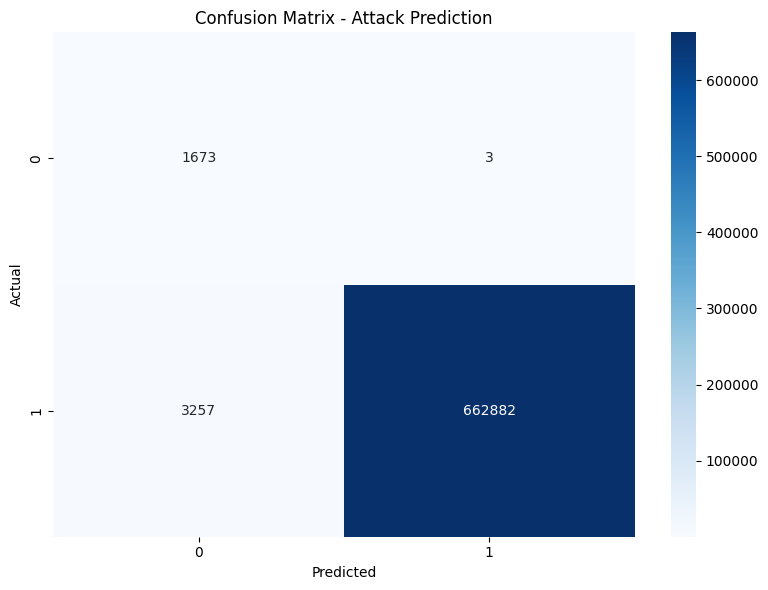


✅ Accuracy: 0.9951
✅ Weighted F1 Score: 0.9963
✅ Macro F1 Score: 0.7520
✅ Macro Precision: 0.6697
✅ Macro Recall: 0.9967
❌ Hamming Loss: 0.004882
📈 ROC AUC Score: 1.0000
📈 PR AUC Score: 1.0000


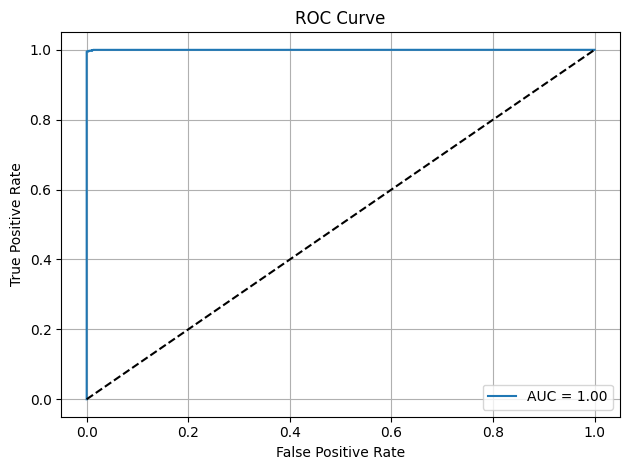

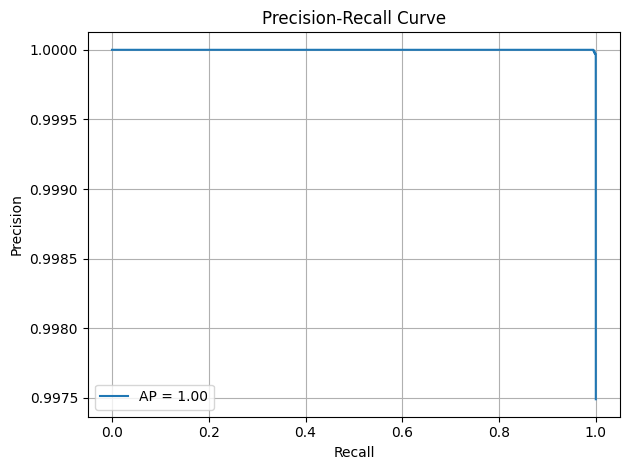

In [ ]:
display_metrics(y_test['attack'], predictions_rfc['attack'], "Attack Prediction",predictions_rfc["y_proba"])




--- Category Prediction ---

📋 Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


   precision    recall  f1-score   support
0   0.967531  0.890729  0.927543  219124.0
1   0.878178  0.956223  0.915541  174590.0
2   0.000000  0.000000  0.000000    1676.0
3   0.984742  0.998563  0.991604  272159.0
4   0.000000  0.000000  0.000000     266.0

📊 Confusion Matrix:


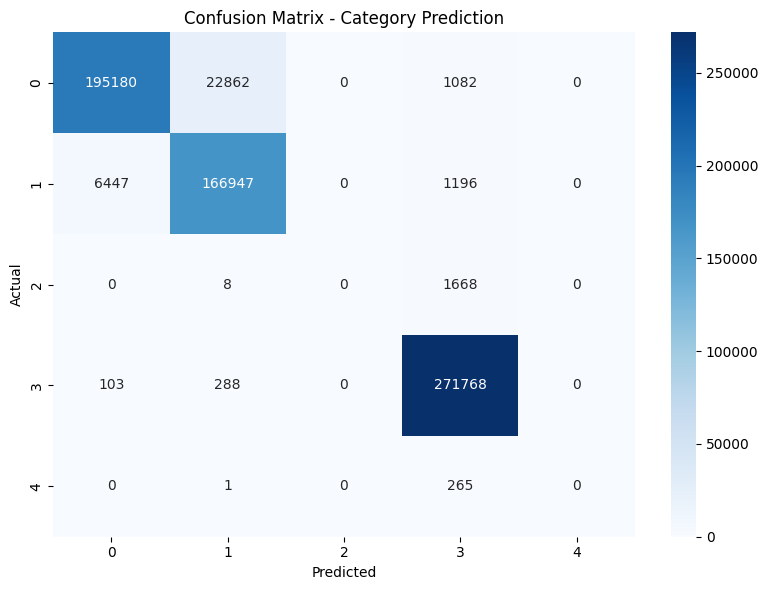


✅ Accuracy: 0.9492
✅ Weighted F1 Score: 0.9478
✅ Macro F1 Score: 0.5669
✅ Macro Precision: 0.5661
✅ Macro Recall: 0.5691
❌ Hamming Loss: 0.050793


In [ ]:
display_metrics(y_test['category'], predictions_rfc['category'], "Category Prediction")



--- Subcategory Prediction ---

📋 Classification Report:
   precision    recall  f1-score   support
0   0.000000  0.000000  0.000000      24.0
1   0.000000  0.000000  0.000000     495.0
2   0.000000  0.000000  0.000000     242.0
3   0.169961  0.995227  0.290339    1676.0
4   0.841988  0.468433  0.601967   70437.0
5   0.845555  0.934251  0.887693  201722.0
6   0.929894  0.917687  0.923750  179025.0
7   0.932089  0.954121  0.942976  214194.0

📊 Confusion Matrix:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


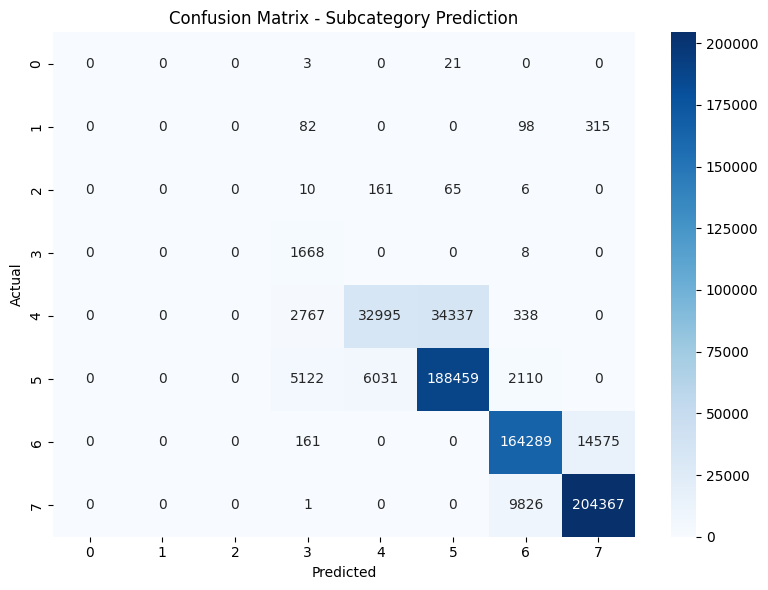


✅ Accuracy: 0.8861
✅ Weighted F1 Score: 0.8824
✅ Macro F1 Score: 0.4558
✅ Macro Precision: 0.4649
✅ Macro Recall: 0.5337
❌ Hamming Loss: 0.113859


In [ ]:
display_metrics(y_test['subcategory'], predictions_rfc['subcategory'], "Subcategory Prediction")

In [ ]:
del rf,predictions_rfc
gc.collect()

XGB graddient boosting


In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train["attack"])

# Predict
y_pred_xgb = xgb_model.predict(X_test)

y_proba = xgb_model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:05:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Attack Prediction ---

📋 Classification Report:
   precision    recall  f1-score   support
0   0.998213  1.000000  0.999106    1676.0
1   1.000000  0.999995  0.999998  666139.0

📊 Confusion Matrix:


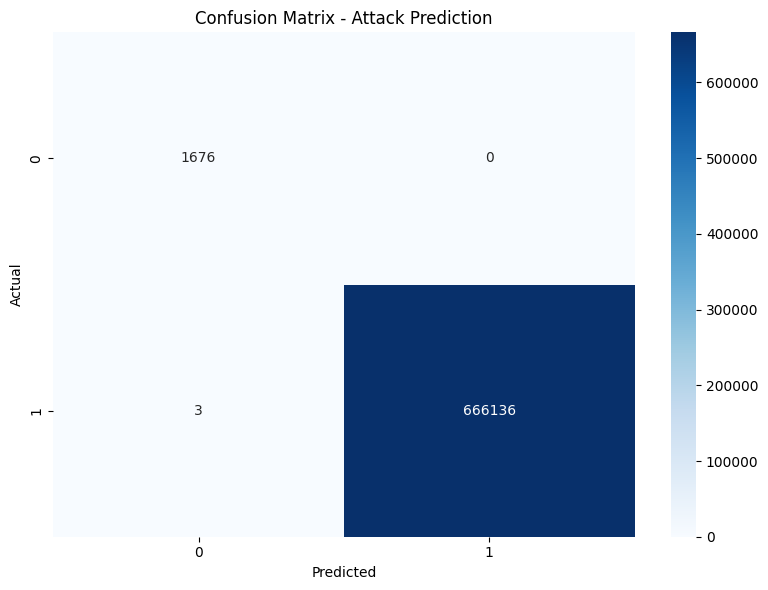


✅ Accuracy: 1.0000
✅ Weighted F1 Score: 1.0000
✅ Macro F1 Score: 0.9996
✅ Macro Precision: 0.9991
✅ Macro Recall: 1.0000
❌ Hamming Loss: 0.000004
📈 ROC AUC Score: 1.0000
📈 PR AUC Score: 1.0000


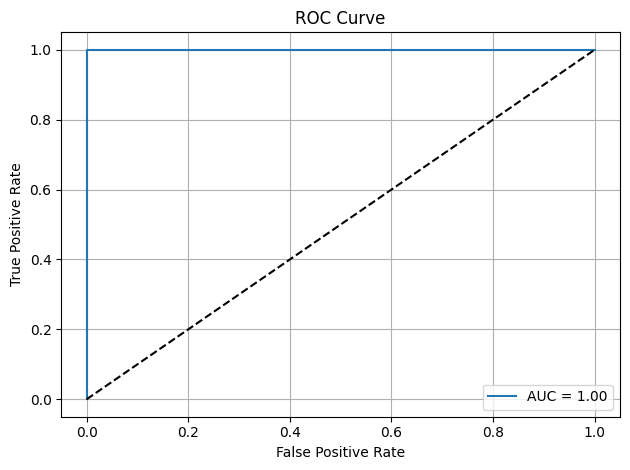

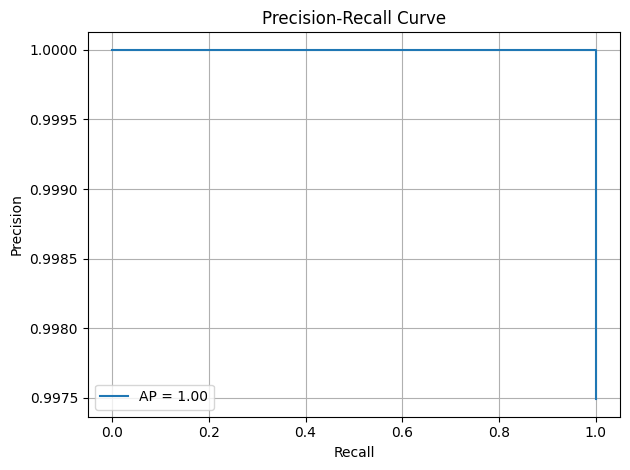

In [ ]:
display_metrics(y_test['attack'], y_pred_xgb, "Attack Prediction",y_proba)


In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train["category"])

# Predict
y_pred_xgb = xgb_model.predict(X_test)



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:06:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Category Prediction ---

📋 Classification Report:
   precision    recall  f1-score   support
0   0.999890  0.999836  0.999863  219124.0
1   0.999794  0.999851  0.999822  174590.0
2   0.900000  0.005370  0.010676    1676.0
3   0.993883  0.999978  0.996921  272159.0
4   0.977358  0.973684  0.975518     266.0

📊 Confusion Matrix:


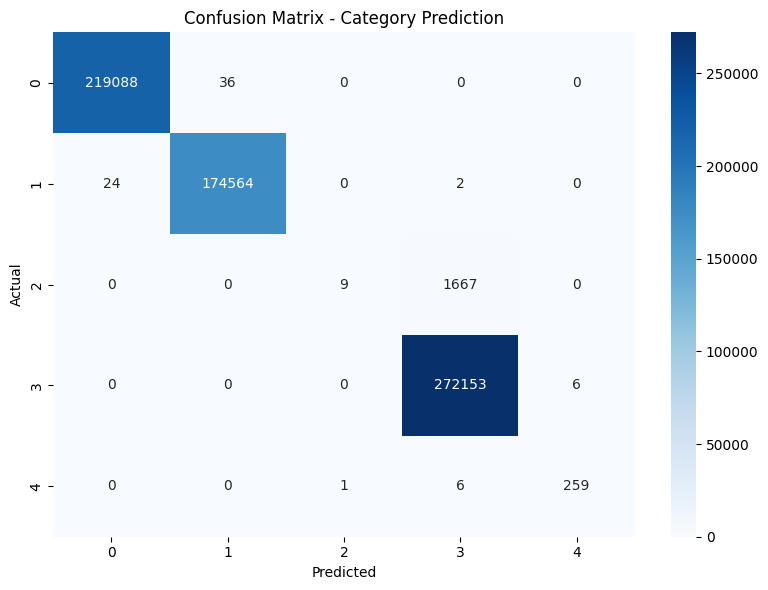


✅ Accuracy: 0.9974
✅ Weighted F1 Score: 0.9962
✅ Macro F1 Score: 0.7966
✅ Macro Precision: 0.9742
✅ Macro Recall: 0.7957
❌ Hamming Loss: 0.002609


In [ ]:
display_metrics(y_test['category'], y_pred_xgb, "Category Prediction")

In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train["subcategory"])

# Predict
y_pred_xgb = xgb_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:12:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Subcategory Prediction ---

📋 Classification Report:
   precision    recall  f1-score   support
0   0.730769  0.791667  0.760000      24.0
1   0.997980  0.997980  0.997980     495.0
2   0.966387  0.950413  0.958333     242.0
3   0.997026  1.000000  0.998511    1676.0
4   0.894067  0.970797  0.930853   70437.0
5   0.989472  0.959806  0.974413  201722.0
6   0.999994  0.999983  0.999989  179025.0
7   0.999986  0.999995  0.999991  214194.0

📊 Confusion Matrix:


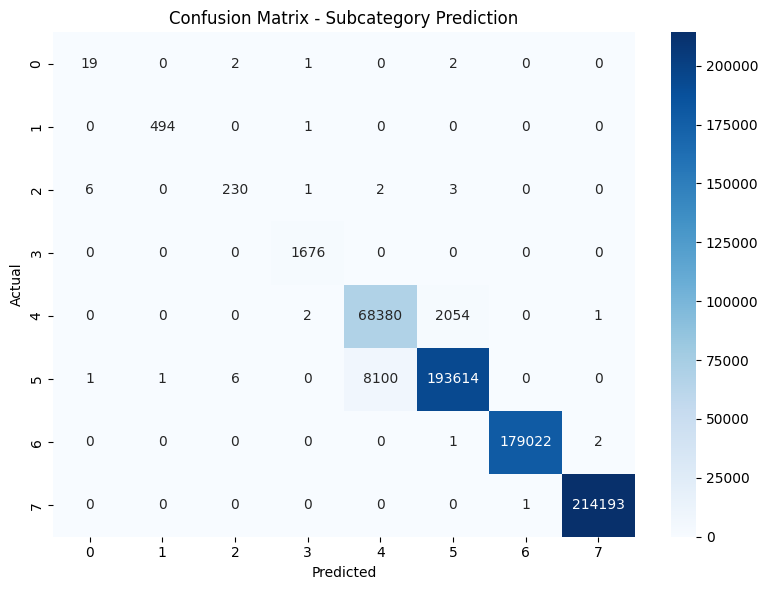


✅ Accuracy: 0.9847
✅ Weighted F1 Score: 0.9849
✅ Macro F1 Score: 0.9525
✅ Macro Precision: 0.9470
✅ Macro Recall: 0.9588
❌ Hamming Loss: 0.015254


In [ ]:
display_metrics(y_test['subcategory'], y_pred_xgb, "Subcategory Prediction")

In [ ]:
del xgb_model,y_pred_xgb
gc.collect()

Logistic Regression


In [ ]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train["attack"])

# Predict
y_pred_logreg = logreg_model.predict(X_test)

y_proba = logreg_model.predict_proba(X_test)[:, 1]


--- Attack Prediction ---

📋 Classification Report:
   precision    recall  f1-score   support
0   0.052071  0.918854  0.098557    1676.0
1   0.999787  0.957914  0.978403  666139.0

📊 Confusion Matrix:


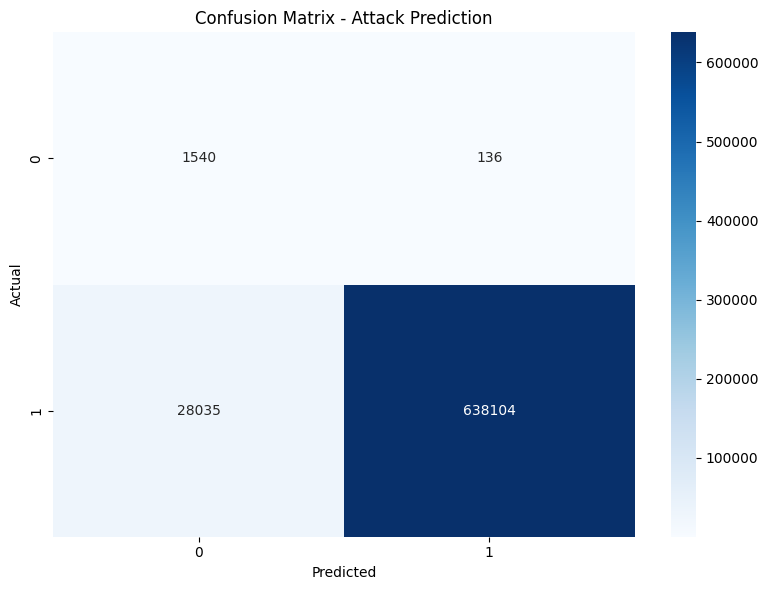


✅ Accuracy: 0.9578
✅ Weighted F1 Score: 0.9762
✅ Macro F1 Score: 0.5385
✅ Macro Precision: 0.5259
✅ Macro Recall: 0.9384
❌ Hamming Loss: 0.042184
📈 ROC AUC Score: 0.9750
📈 PR AUC Score: 0.9999


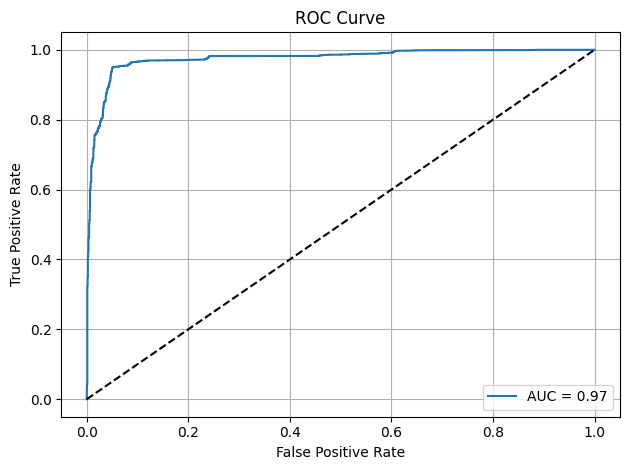

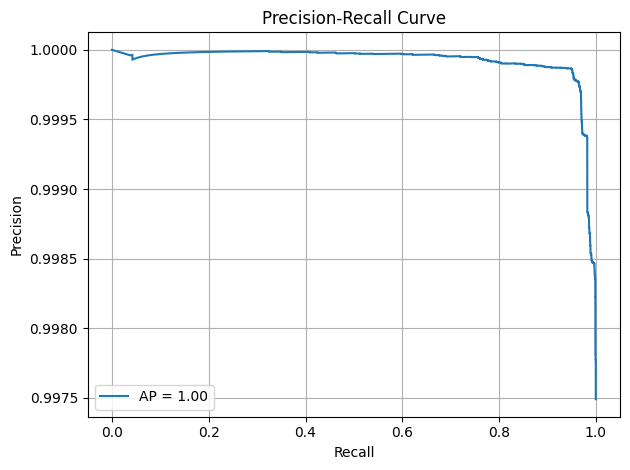

In [ ]:
display_metrics(y_test['attack'], y_pred_logreg, "Attack Prediction",y_proba)


In [ ]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train["category"])

# Predict
y_pred_logreg = logreg_model.predict(X_test)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- Category Prediction ---

📋 Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


   precision    recall  f1-score   support
0   0.916876  0.847995  0.881091  219124.0
1   0.824107  0.905499  0.862888  174590.0
2   0.000000  0.000000  0.000000    1676.0
3   0.992796  0.997020  0.994904  272159.0
4   0.000000  0.000000  0.000000     266.0

📊 Confusion Matrix:


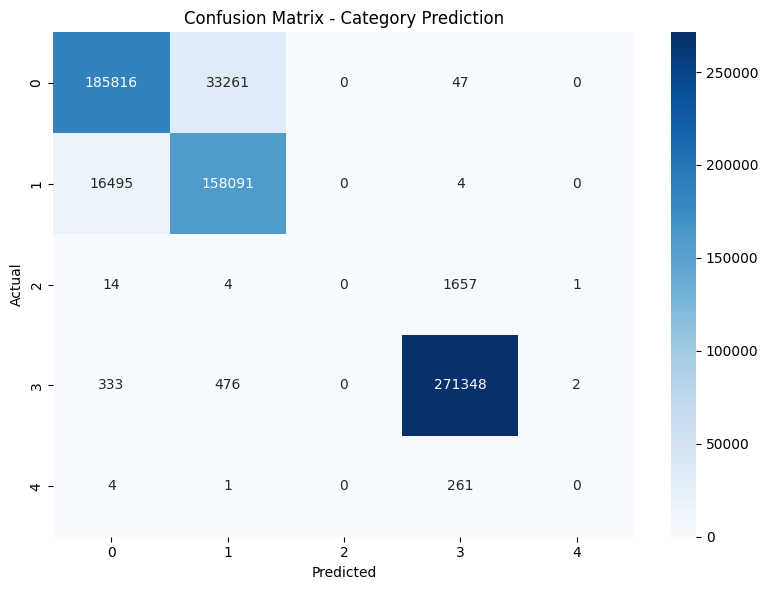


✅ Accuracy: 0.9213
✅ Weighted F1 Score: 0.9202
✅ Macro F1 Score: 0.5478
✅ Macro Precision: 0.5468
✅ Macro Recall: 0.5501
❌ Hamming Loss: 0.078704


In [ ]:
display_metrics(y_test['category'], y_pred_logreg, "Category Prediction")

In [ ]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train["subcategory"])

# Predict
y_pred_logreg = logreg_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



--- Subcategory Prediction ---

📋 Classification Report:
   precision    recall  f1-score   support
0   0.095238  0.083333  0.088889      24.0
1   0.000000  0.000000  0.000000     495.0
2   0.000000  0.000000  0.000000     242.0
3   0.179001  0.985680  0.302980    1676.0
4   0.817548  0.720317  0.765859   70437.0
5   0.912560  0.912682  0.912621  201722.0
6   0.938893  0.876006  0.906360  179025.0
7   0.902595  0.959159  0.930018  214194.0

📊 Confusion Matrix:


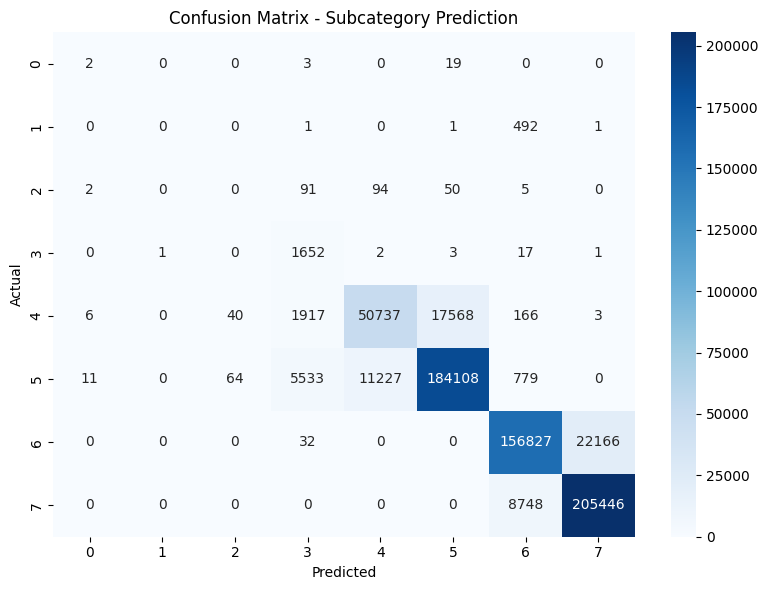


✅ Accuracy: 0.8966
✅ Weighted F1 Score: 0.8985
✅ Macro F1 Score: 0.4883
✅ Macro Precision: 0.4807
✅ Macro Recall: 0.5671
❌ Hamming Loss: 0.103386


In [ ]:
display_metrics(y_test['subcategory'], y_pred_logreg, "Subcategory Prediction")

In [ ]:
del logreg_model,y_pred_logreg
gc.collect()

Stacked Model

In [24]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
rf = RandomForestClassifier(class_weight="balanced")
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


meta_model = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=200,class_weight="balanced")


stacked = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf)],
    final_estimator=meta_model,
    cv=cv,
    passthrough=False,
    n_jobs=1
)


stacked.fit(X_train, y_train["attack"])



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:03:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:23:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:24:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:25:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be r

StackingClassifier(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None, gamma=None,
                                              grow_polic...
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced'))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      max_iter=200,
                                                      multi_class='multinomial'),
                   n_jobs=1)


--- Attack ---

📋 Classification Report:
   precision    recall  f1-score   support
0   0.998953  0.998953  0.998953    1910.0
1   0.999997  0.999997  0.999997  733925.0

📊 Confusion Matrix:


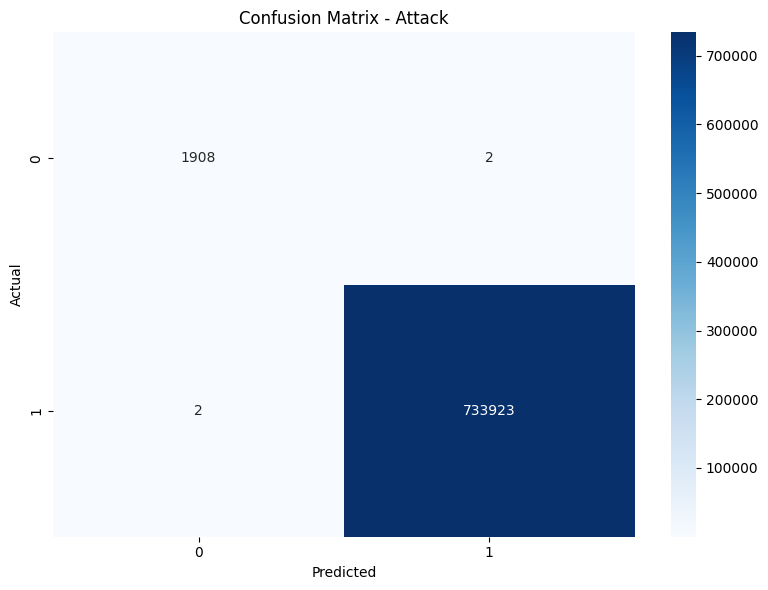


✅ Accuracy: 1.0000
✅ Weighted F1 Score: 1.0000
✅ Macro F1 Score: 0.9995
✅ Macro Precision: 0.9995
✅ Macro Recall: 0.9995
❌ Hamming Loss: 0.000005
📈 ROC AUC Score: 1.0000
📈 PR AUC Score: 1.0000


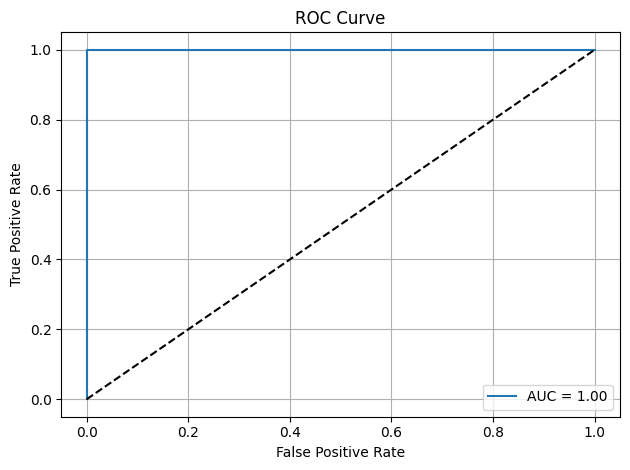

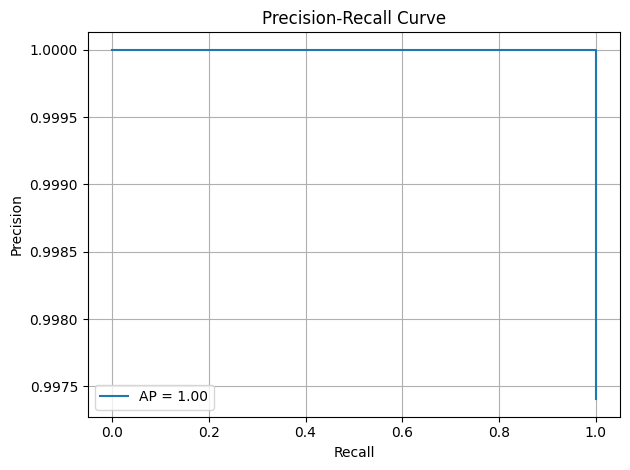

In [25]:
y_pred_attack = stacked.predict(X_test)
y_proba = stacked.predict_proba(X_test)[:, 1]
display_metrics(y_test["attack"], y_pred_attack,"Attack",y_proba)

In [26]:
del y_proba,stacked
gc.collect()

11173

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:18:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:34:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:38:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:42:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be r


--- category ---

📋 Classification Report:
   precision    recall  f1-score   support
0   0.999997  0.999969  0.999983  385325.0
1   1.000000  0.999985  0.999992  330052.0
2   0.997380  0.597906  0.747627    1910.0
3   0.959486  0.999726  0.979192   18217.0
4   0.945402  0.993958  0.969072     331.0

📊 Confusion Matrix:


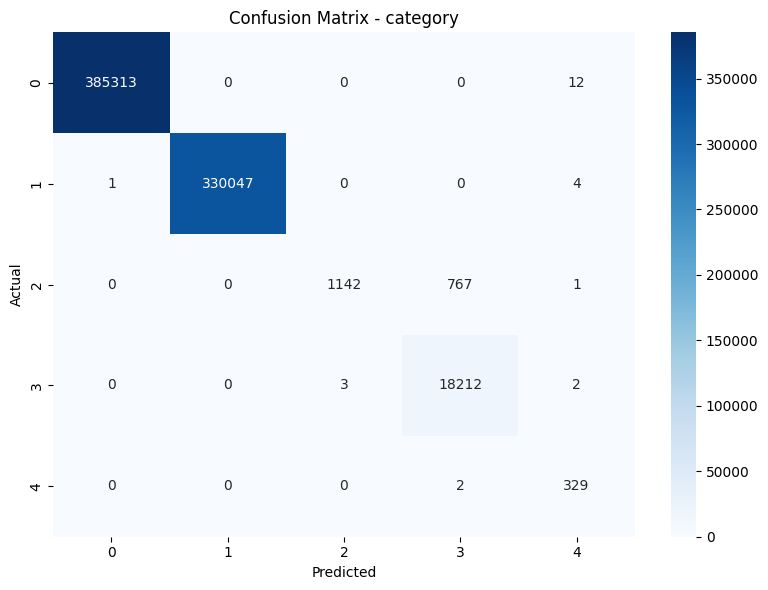


✅ Accuracy: 0.9989
✅ Weighted F1 Score: 0.9988
✅ Macro F1 Score: 0.9392
✅ Macro Precision: 0.9805
✅ Macro Recall: 0.9183
❌ Hamming Loss: 0.001076


In [27]:

stacked = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf)],
    final_estimator=meta_model,
    cv=cv,
    passthrough=False,
    n_jobs=1
)
X_cat = np.concatenate([X_train, y_train["attack"].values.reshape(-1, 1)], axis=1)

stacked.fit(X_cat, y_train["category"])


X_cat_test = np.concatenate([X_test, y_pred_attack.reshape(-1, 1)], axis=1)

y_pred_category = stacked.predict(X_cat_test)
display_metrics(y_test["category"], y_pred_category,title="category")



In [28]:
del stacked
gc.collect()

6271

In [29]:
stacked = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf)],
    final_estimator=meta_model,
    cv=cv,
    passthrough=False,
    n_jobs=1
)

X_subcat = np.concatenate([X_cat, y_train["category"].values.reshape(-1, 1)], axis=1)

stacked.fit(X_subcat, y_train["subcategory"])
X_subcat_test = np.concatenate([X_cat_test, y_pred_category.reshape(-1, 1)], axis=1)

y_pred = stacked.predict(X_subcat_test)




/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:30:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:09:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:15:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:21:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be r


--- Subcategory ---

📋 Classification Report:
   precision    recall  f1-score   support
0   0.460000  0.958333  0.621622      24.0
1   1.000000  0.997980  0.998989     495.0
2   1.000000  0.967427  0.983444     307.0
3   0.998953  0.998953  0.998953    1910.0
4   0.994163  0.998325  0.996240    3583.0
5   0.999453  0.998428  0.998940   14634.0
6   0.999997  0.999950  0.999973  318636.0
7   0.999995  0.999995  0.999995  396246.0

📊 Confusion Matrix:


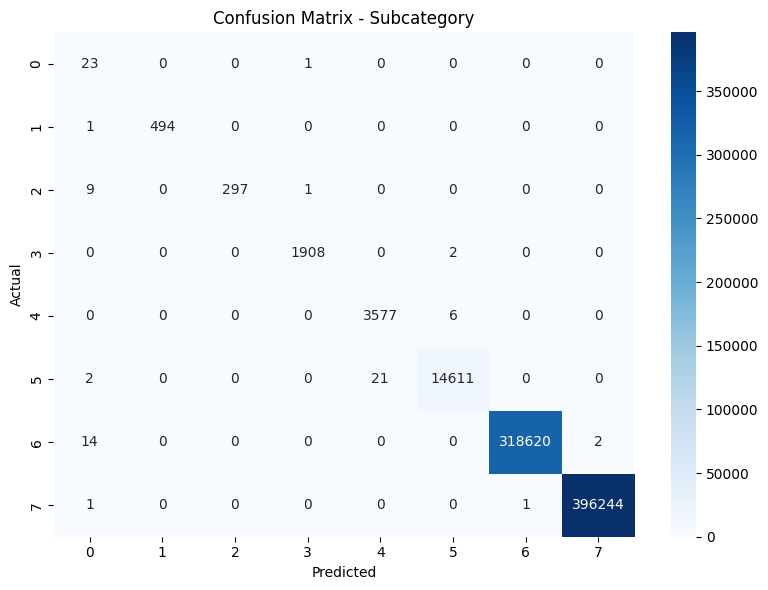


✅ Accuracy: 0.9999
✅ Weighted F1 Score: 0.9999
✅ Macro F1 Score: 0.9498
✅ Macro Precision: 0.9316
✅ Macro Recall: 0.9899
❌ Hamming Loss: 0.000083


In [30]:


display_metrics(y_test["subcategory"], y_pred, title="Subcategory")

